In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
import numpy as np
import time
from datetime import datetime, date, timedelta
from tqdm.auto import tqdm

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import yfinance as yf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('default')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, torch.__version__)

cuda 2.0.0+cu118


In [4]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

# Data preload

In [15]:
# load S&P-500 tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tickers_df = table[0]
print(tickers_df.Symbol.tolist())

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CV

In [19]:
it_tickers = tickers_df.loc[tickers_df['GICS Sector'] == 'Information Technology'].Symbol

In [52]:
def options_chain(symbol, type='call'):

    tk = yf.Ticker(symbol)
    stock_price = tk.history().iloc[-1,3]
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls if type=='call' else opt.puts)
        opt['expir'] = e
        opt['stock_price'] = stock_price
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expir'] = pd.to_datetime(options['expir']) + timedelta(days = 1)
    options['maturity'] = (options['expir'] - datetime.today()).dt.days / 256
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['opt_price'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns=[
        'openInterest', 'inTheMoney', 'contractSize', 
        'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'
    ])
    options = options.rename(columns={'impliedVolatility' : 'vol'})
    
    return options

In [61]:
it_calls_options = pd.concat([options_chain(ticker, type='call') for ticker in tqdm(it_tickers)])
it_puts_options = pd.concat([options_chain(ticker, type='put') for ticker in tqdm(it_tickers)])

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [62]:
display(it_calls_options.info())
display(it_puts_options.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16950 entries, 0 to 92
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contractSymbol  16950 non-null  object        
 1   strike          16950 non-null  float64       
 2   bid             16949 non-null  float64       
 3   ask             16950 non-null  float64       
 4   volume          15617 non-null  float64       
 5   vol             16950 non-null  float64       
 6   expir           16950 non-null  datetime64[ns]
 7   stock_price     16950 non-null  float64       
 8   maturity        16950 non-null  float64       
 9   opt_price       16949 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 1.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16604 entries, 0 to 108
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contractSymbol  16604 non-null  object        
 1   strike          16604 non-null  float64       
 2   bid             16604 non-null  float64       
 3   ask             16604 non-null  float64       
 4   volume          15122 non-null  float64       
 5   vol             16604 non-null  float64       
 6   expir           16604 non-null  datetime64[ns]
 7   stock_price     16604 non-null  float64       
 8   maturity        16604 non-null  float64       
 9   opt_price       16604 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 1.4+ MB


None

In [65]:
it_calls_options.to_pickle('data/it_calls.pkl')
it_puts_options.to_pickle('data/it_puts.pkl')

In [86]:
available_tickers = []
for tick in tqdm(tickers_df.Symbol):
    yftick = yf.Ticker(tick) 
    if len(yftick.history()) > 0 and len(yftick.options) > 0:
        available_tickers.append(tick)
    elif len(yftick.options) == 0:
        print(f'{tick} - no options')

len(available_tickers)

  0%|          | 0/503 [00:00<?, ?it/s]

BRK.B: No data found, symbol may be delisted
BRK.B - no options
BF.B: No data found for this date range, symbol may be delisted
BF.B - no options
NVR - no options


500

In [87]:
sp500_calls_options = pd.concat([options_chain(ticker, type='call') for ticker in tqdm(sorted(available_tickers))])
sp500_puts_options = pd.concat([options_chain(ticker, type='put') for ticker in tqdm(sorted(available_tickers))])

display(sp500_calls_options.info())
display(sp500_puts_options.info())

sp500_calls_options.to_pickle('data/sp500_calls.pkl')
sp500_puts_options.to_pickle('data/sp500_puts.pkl')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96715 entries, 0 to 113
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contractSymbol  96715 non-null  object        
 1   strike          96715 non-null  float64       
 2   bid             96493 non-null  float64       
 3   ask             96496 non-null  float64       
 4   volume          87977 non-null  float64       
 5   vol             96715 non-null  float64       
 6   expir           96715 non-null  datetime64[ns]
 7   stock_price     96715 non-null  float64       
 8   maturity        96715 non-null  float64       
 9   opt_price       96493 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 8.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95689 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contractSymbol  95689 non-null  object        
 1   strike          95689 non-null  float64       
 2   bid             95446 non-null  float64       
 3   ask             95446 non-null  float64       
 4   volume          86229 non-null  float64       
 5   vol             95689 non-null  float64       
 6   expir           95689 non-null  datetime64[ns]
 7   stock_price     95689 non-null  float64       
 8   maturity        95689 non-null  float64       
 9   opt_price       95446 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 8.0+ MB


None

# Training

In [5]:
sp500_calls_options = pd.read_pickle('data/sp500_calls.pkl')
sp500_puts_options = pd.read_pickle('data/sp500_puts.pkl')

In [143]:
columns = [
    # 'S2K',
    'log_S2K',
    'T',
    'r',
    'log_V2K'
]
target = 'sigma'

In [144]:
df = sp500_puts_options.loc[(sp500_puts_options.opt_price != 0) & sp500_puts_options.opt_price.notna()].copy()
df['S2K'] = df.stock_price / df.strike
df['log_S2K'] = np.log(df.S2K)
df['T'] = df.maturity
df['r'] = np.random.uniform(0.025, 0.075, len(df))
df['log_V2K'] = np.log(df.opt_price / df.strike)
df['sigma'] = df.vol
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93405 entries, 0 to 115
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contractSymbol  93405 non-null  object        
 1   strike          93405 non-null  float64       
 2   bid             93405 non-null  float64       
 3   ask             93405 non-null  float64       
 4   volume          84477 non-null  float64       
 5   vol             93405 non-null  float64       
 6   expir           93405 non-null  datetime64[ns]
 7   stock_price     93405 non-null  float64       
 8   maturity        93405 non-null  float64       
 9   opt_price       93405 non-null  float64       
 10  S2K             93405 non-null  float64       
 11  log_S2K         93405 non-null  float64       
 12  T               93405 non-null  float64       
 13  r               93405 non-null  float64       
 14  log_V2K         93405 non-null  float64       
 15  sigm

In [145]:
df[columns + [target]].describe()

,log_S2K,T,r,log_V2K,sigma
count,93405.000000,93405.000000,93405.000000,93405.000000,93405.000000
mean,0.093745,0.700517,0.050003,-3.669009,0.480093
std,0.506524,0.802322,0.014431,1.979129,0.526018
min,-3.954266,0.019531,0.025000,-11.289782,0.000000
25%,-0.077791,0.101562,0.037551,-4.915325,0.290382
50%,0.088765,0.320312,0.050037,-3.388775,0.392981
75%,0.313400,1.031250,0.062442,-2.121110,0.535588
max,4.588931,3.765625,0.074999,0.928219,13.875001


In [146]:
class MyDataset(Dataset):
    def __init__(self, df, columns, target):
        self.df = df
        self.columns = columns
        self.target = target
        self.data_tensor = torch.Tensor(df[columns].values)
        self.target_tensor = torch.Tensor(df[target].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.data_tensor[idx], self.target_tensor[idx])

In [147]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_ds = MyDataset(train_df, columns, target)
test_ds = MyDataset(test_df, columns, target)

train_dl = DataLoader(train_ds, batch_size=5_000, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=5_000, shuffle=False)

In [148]:
class ANN(nn.Module):
    def __init__(self, struct, bn=False):
        super().__init__()
        layers = []
        for i,l in enumerate(struct[:-1]):
            if bn:
                layers.append(nn.BatchNorm1d(struct[i]))
            
            layers += [
                nn.Linear(struct[i], struct[i+1]),
                nn.ReLU()
            ]

        self.net = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.net(x)

In [149]:
struct_ann = [len(columns), 256, 512, 256, 64, 1]
model = ANN(struct_ann, bn=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [150]:
def train(model, optimizer, criterion, dataloader_train, dataloader_test, num_epochs, noise=None, writer=None):
    logs = {
        'train_loss' : [],
        'test_loss' : []
    }
    model.train()
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        train_running_loss, grad_norm = 0.0, 0.0
        for iter_num, (X,y) in enumerate(dataloader_train):
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            if noise is not None:
                y = y + torch.rand_like(y) * noise
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            train_running_loss += loss.item()
            loss.backward()
            
            optimizer.step()

            if writer is not None:
                writer.add_scalars("loss_iter", {'train' : loss}, iter_num + epoch * len(dataloader_train))

        logs['train_loss'].append(train_running_loss/len(dataloader_train))

        running_loss = 0.0
        for iter_num, (X,y) in enumerate(dataloader_test):
            with torch.no_grad():
                X = X.to(device)
                y = y.to(device).unsqueeze(1)
                out = model(X)
                loss = criterion(out, y)
                running_loss += loss.item()
                if writer is not None:
                    writer.add_scalars('loss_iter', {'test' : loss}, iter_num + epoch * len(dataloader_test))

        logs['test_loss'].append(running_loss/len(dataloader_test))
        
        if writer is not None:
            writer.add_scalars('loss_epoch', {
                'train': train_running_loss/len(dataloader_train),
                'test': running_loss/len(dataloader_test),
            }, epoch)

    if writer is not None:
        writer.close()
        
    return logs

In [151]:
EXP_NAME = 'PUT_1'
logs = train(model, optimizer, criterion, 
             train_dl, test_dl, 
             num_epochs=100, noise=None,
             writer=SummaryWriter(f'logs/{EXP_NAME}'))

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [117]:
torch.save(model.state_dict(), f'models/best_PUT.pth')

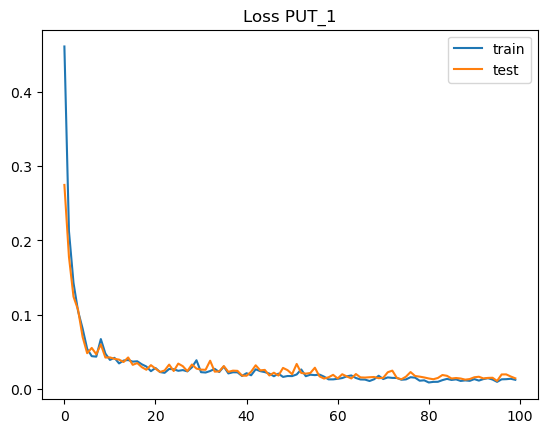

In [152]:
plt.plot(logs['train_loss'], label='train')
plt.plot(logs['test_loss'], label='test')
plt.title(f'Loss {EXP_NAME}')
plt.legend()
plt.show()

In [153]:
np.argmin(logs['test_loss'])

95

In [119]:
# msft = df.loc[df.apply(lambda x: 'MSFT' in x.contractSymbol, 1)]
# msft.info()

In [120]:
# msft_tensor = torch.tensor(msft[columns].values, dtype=torch.float32).to(device)
# model.eval()
# with torch.no_grad():
#     msft_predict = model(msft_tensor).detach().cpu().numpy()

# MSE(msft.vol, msft_predict)

In [121]:
# for mat in msft.maturity.unique():
#     mask = msft.maturity == mat
#     plt.scatter(msft.loc[mask].strike, msft_predict[mask], label='NN')
#     plt.scatter(msft.loc[mask].strike, msft.loc[mask].vol, label='Market')
#     plt.title(f'{mat} - {msft.loc[mask].iloc[0].expir}')
#     plt.show()

# Old data

In [20]:
data_description = '''
    msft_calls - list of pandas DataFrames, every item corresponds expiration 
                 expiration date from `expirations`. Each DF contains trading
                 info about call option
    
    msft_puts - same but for put options
    
    expirations - tuple of expirations dates in string format `YYYY-MM-DD`
'''

msft_calls = pd.read_pickle('data/msft_calls.pickle')
msft_puts = pd.read_pickle('data/msft_puts.pickle')
expirations = pd.read_pickle('data/expirations.pickle')

msft_stock_price = 294.3900146484375
day = '2022-03-16'

In [123]:
maturities = [
    (
        datetime.strptime(expiration, '%Y-%m-%d') - 
        (datetime.strptime(day, '%Y-%m-%d') if day else datetime.today())
    ).days / 256 
    for expiration in expirations
]

In [124]:
maturities = np.array(maturities)

df_lens = np.array([len(df) for df in msft_puts])
indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

msft_puts = [msft_puts[i] for i in indxs]
expirations = [expirations[i] for i in indxs]
maturities = maturities[indxs]
len(msft_puts), len(expirations), len(maturities)

(12, 12, 12)

In [125]:
strikes = msft_puts[0].strike
for row in msft_puts:
  strikes = np.intersect1d(strikes, row.strike)
set_strikes = set(strikes)
print(len(strikes))

28


In [126]:
opt_prices = np.array([(df.bid + df.ask)[df.strike.isin(strikes)] / 2 for df in msft_puts])
opt_prices[np.isnan(opt_prices)] = 3.5e-2
opt_prices.shape

(12, 28)

In [127]:
vols = np.array([df.impliedVolatility.loc[df.strike.isin(strikes)] for df in msft_puts])
vols.shape

(12, 28)

In [128]:
columns

['log_S2K', 'T', 'r']

In [174]:
%%time
model.cpu()
model.eval()
surface = np.zeros((len(maturities), len(strikes)), dtype=float)

for i, t in enumerate(zip(maturities)):
    # cur_batch = torch.tensor(np.vstack([
    #     np.log(opt_prices[i] / strikes),
    #     np.repeat(0.05, len(strikes)),
    #     np.repeat(t, len(strikes)),
    #     np.log(msft_stock_price / strikes)
    # ]), dtype=torch.float32).T.to(device)
    cur_batch = torch.tensor(np.vstack([
        np.log(msft_stock_price / strikes),
        np.repeat(t, len(strikes)),
        np.repeat(0.05, len(strikes)),
        # np.log(opt_prices[i] / strikes),
    ]), dtype=torch.float32).T
    
    with torch.no_grad():
        surface[i,:] = model(cur_batch).numpy().squeeze(1)

CPU times: total: 15.6 ms
Wall time: 8.03 ms


In [175]:
MSE(vols, surface)

0.003076644035045507

In [92]:
def plot_surface(X,Y,Z, title):
    X, Y = np.meshgrid(X, Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,6))
    ax.set_title(title)

    surf = ax.plot_surface(X, Y, Z, 
                        cmap=cm.coolwarm,
                        linewidth=0.1,
                        edgecolor='white')

    fig.colorbar(surf, shrink=0.3, aspect=10)
    ax.set_zlabel('Implied volatility')
    ax.set_xlabel('Strike, $')
    ax.set_ylabel('Maturity, years')
    plt.show()

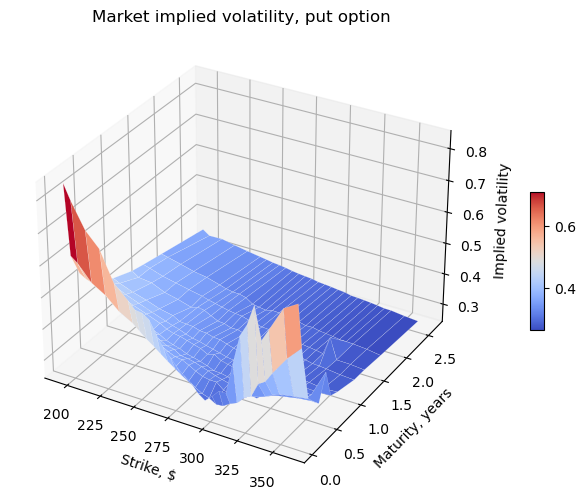

In [135]:
plot_surface(strikes, maturities, vols, title='Market implied volatility, put option')

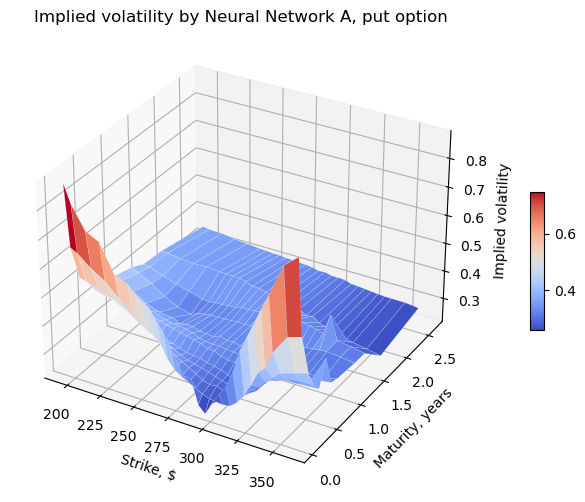

In [159]:
plot_surface(strikes, maturities, surface, title='Implied volatility by Neural Network A, put option')

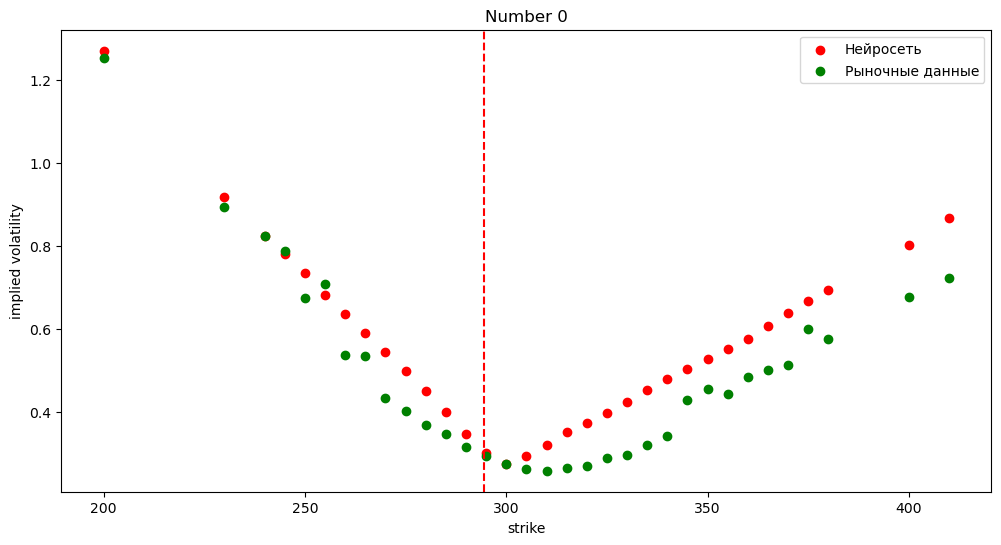

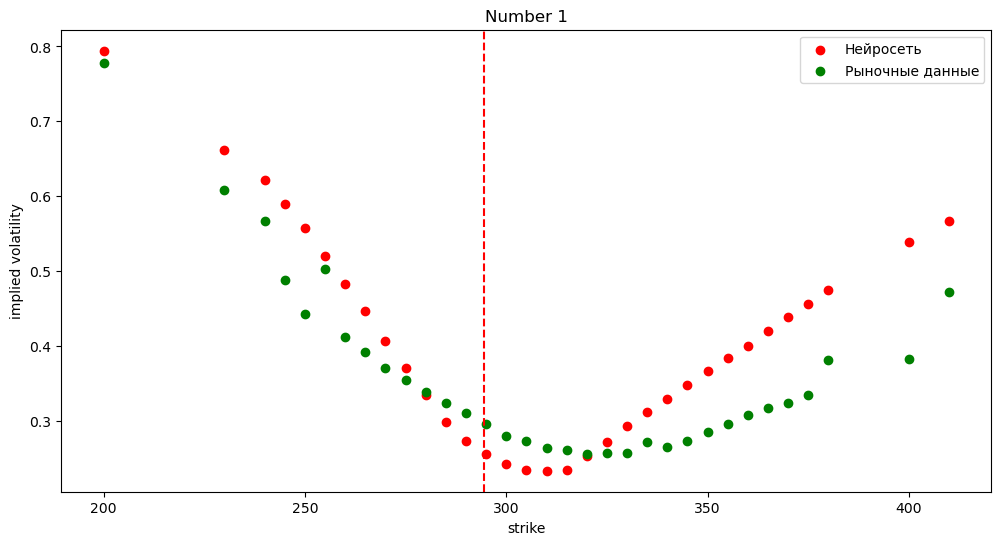

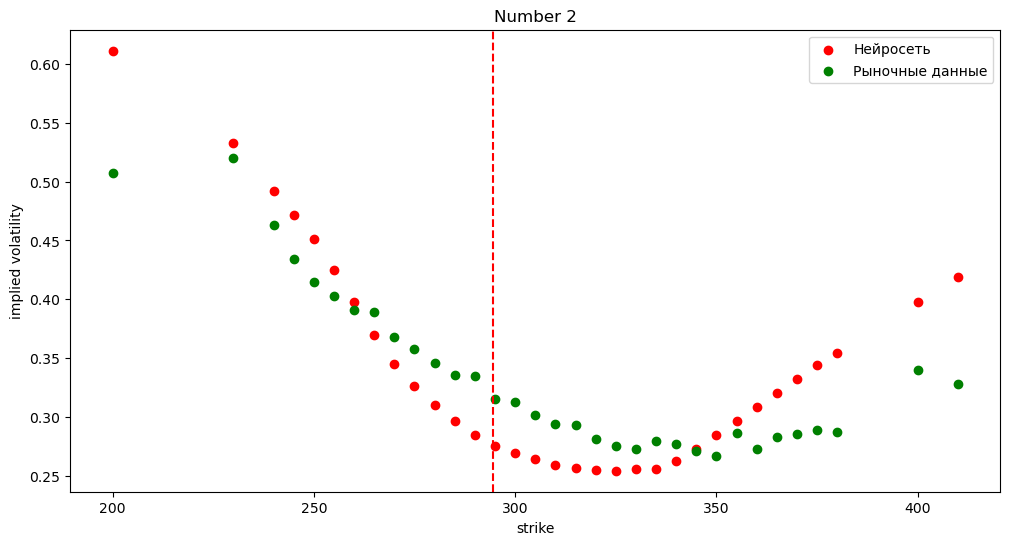

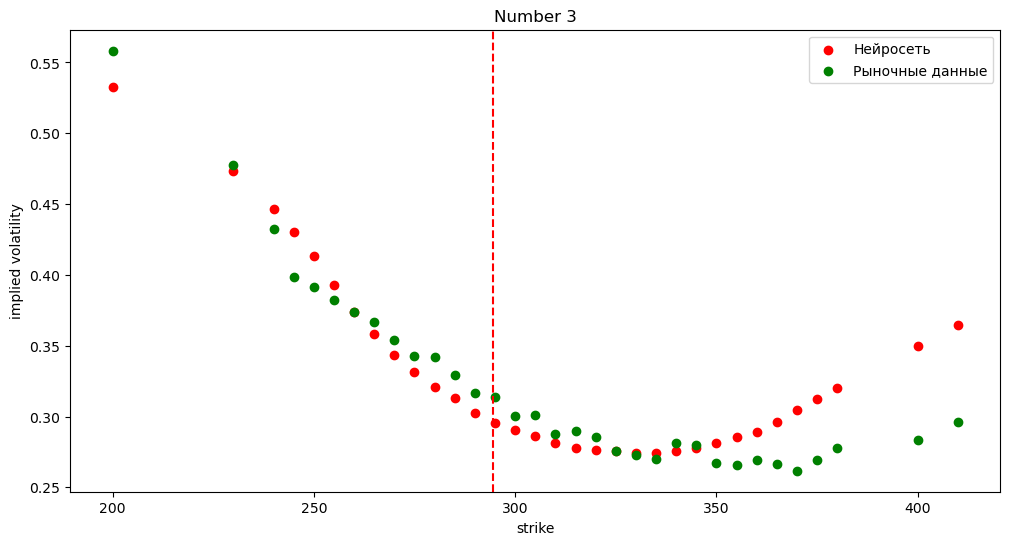

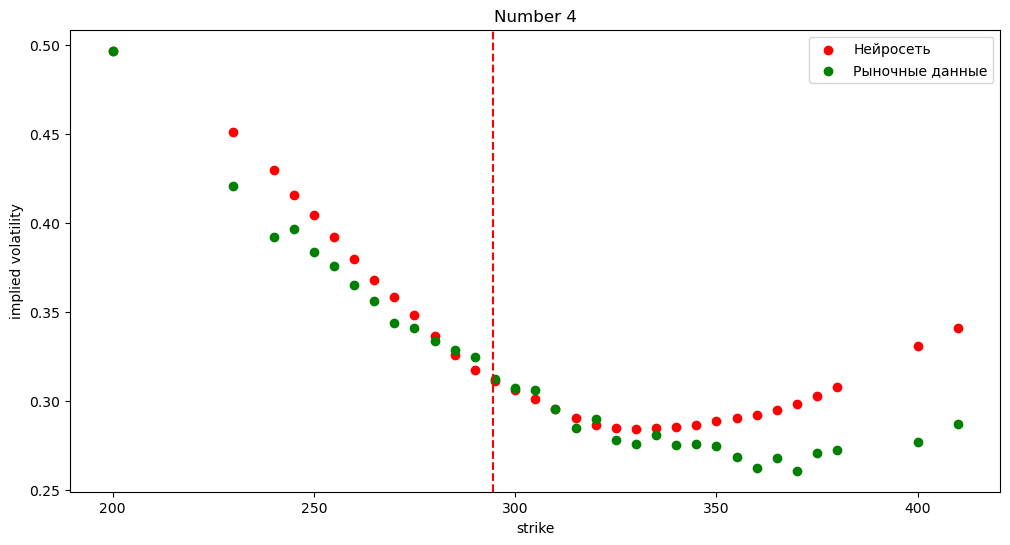

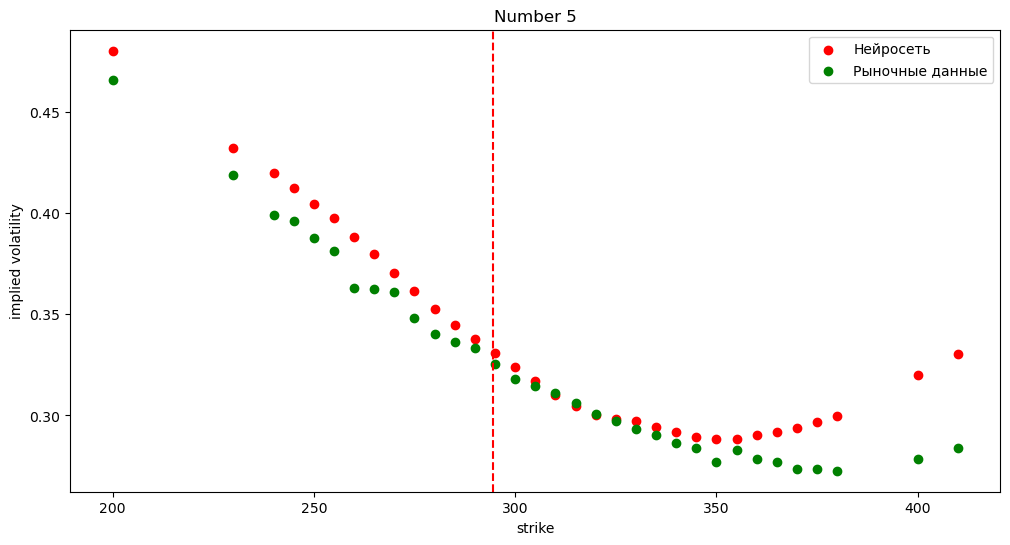

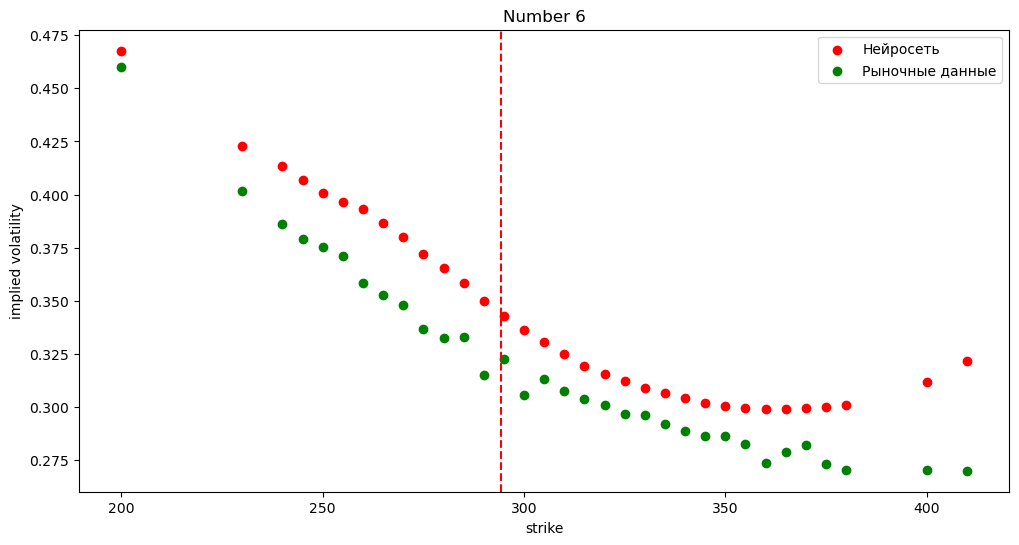

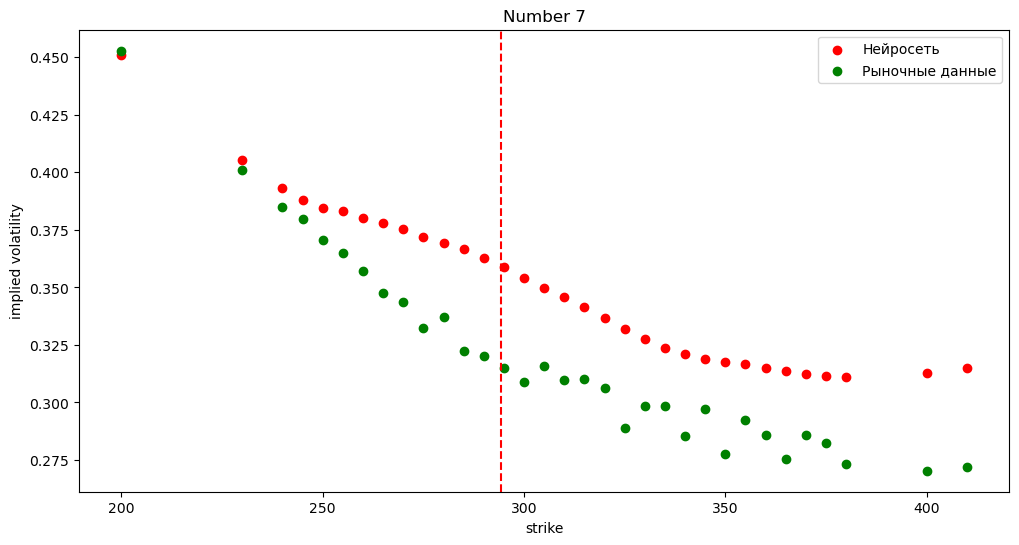

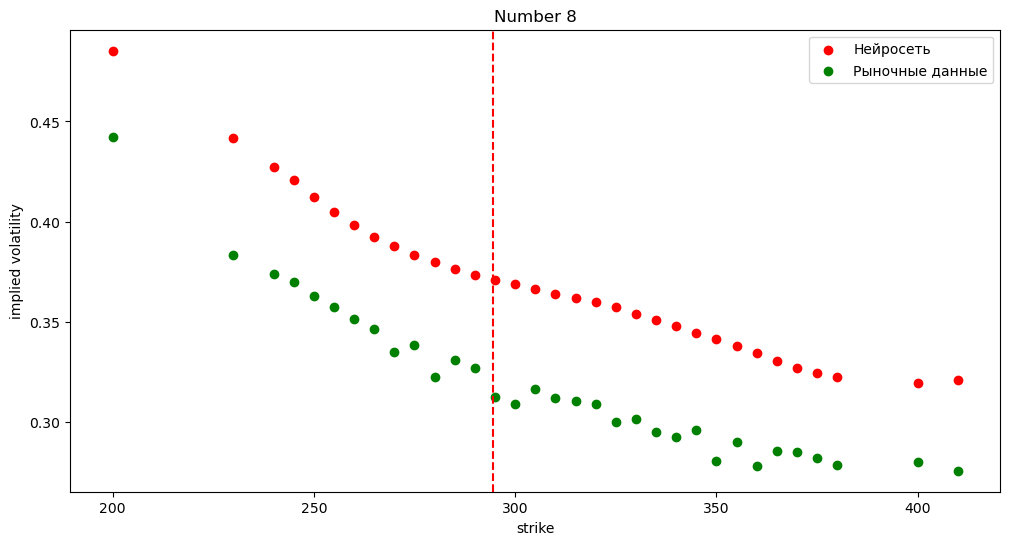

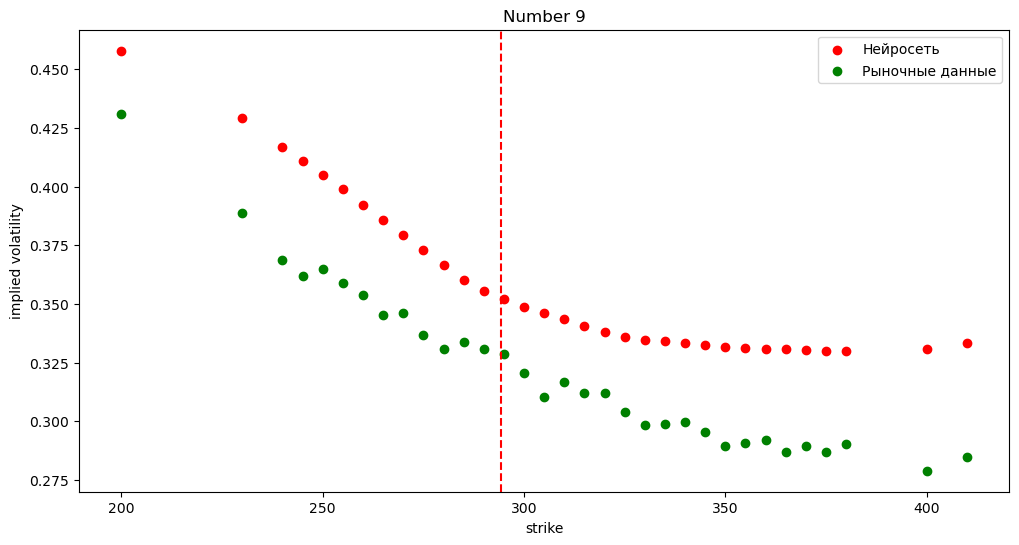

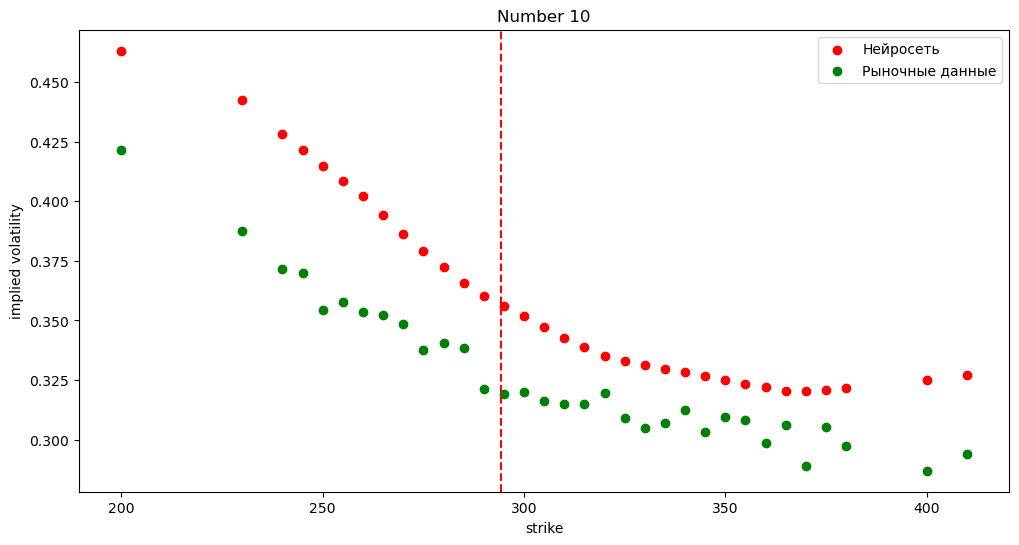

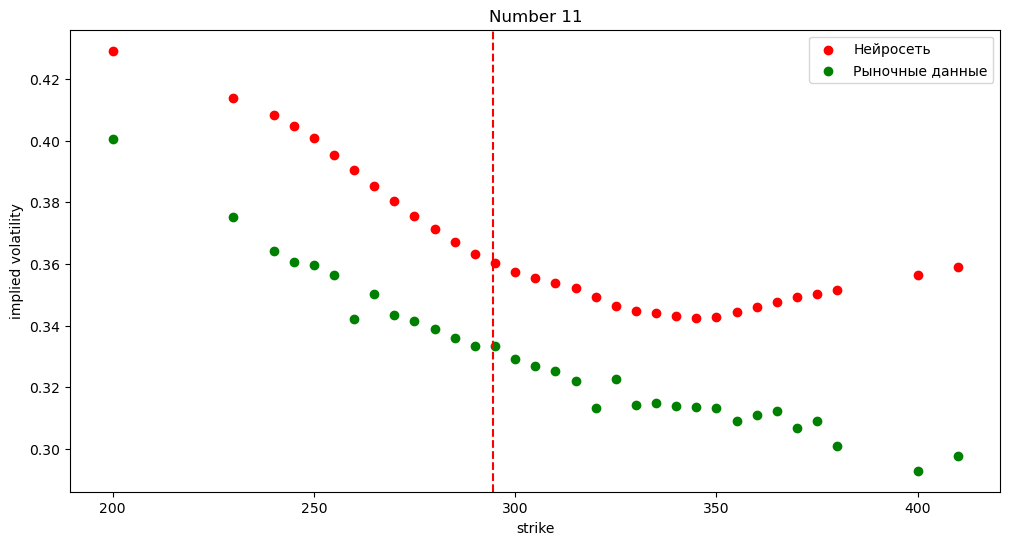

In [97]:
for i in range(len(maturities)):
    plt.figure(figsize=(12,6))
    # plt.title('Восстановление улыбки волатильности с помощью нейросети')
    plt.title(f'Number {i}')
    plt.scatter(x=strikes, y=surface[i], c='r', label='Нейросеть')
    plt.scatter(x=strikes, y=vols[i], c='g', label='Рыночные данные')
    plt.axvline(x=msft_stock_price, c='r', linestyle='--')
    plt.xlabel('strike')
    plt.ylabel('implied volatility')
    plt.legend()
    plt.show()

# All data

In [170]:
struct_ann[0] = 3
model = ANN(struct_ann, bn=True)
model.load_state_dict(torch.load('models/best_PUT_no_opt.pth'))

<All keys matched successfully>

In [171]:
sse = 0
cnt = 0
model.eval()
for i, (t, df) in enumerate(zip(maturities, msft_puts)):
    cnt += len(df)

    cur_batch = torch.tensor(np.vstack([
        np.log(msft_stock_price / df.strike),
        np.repeat(t, len(df.strike)),
        np.repeat(0.05, len(df.strike)),
        # np.log((df.bid + df.ask) / 2 / df.strike),
    ]), dtype=torch.float32).T
    
    with torch.no_grad():
        nn_vols = model(cur_batch).numpy().squeeze(1)

    # plt.scatter(df.strike, nn_vols, label='NN')
    # plt.scatter(df.strike, df.impliedVolatility, label='Market')
    # plt.legend()
    # plt.show()
    
    sse += np.sum(np.square(nn_vols - df.impliedVolatility))

sse / cnt

0.016381474742002976

In [176]:
nn_opt_prices = black_scholes(msft_stock_price, strikes, maturities[:,None], 0.05, surface, 'put')
MSE(opt_prices, nn_opt_prices)

7.530318207431141

In [177]:
mask1 = maturities <= 1
mask2 = maturities > 1
print('Near', MSE(opt_prices[mask1], nn_opt_prices[mask1]))
print('Far', MSE(opt_prices[mask2], nn_opt_prices[mask2]))

Near 3.4451742870681805
Far 15.700606048157065


In [104]:
def plot_opt_prices(
    strikes, 
    opt_prices, 
    expirations,
    stock_price=msft_stock_price, 
    title=''
):
    if opt_prices.shape[0] == len(expirations):
        opt_prices = opt_prices.T
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.plot(
        np.repeat(strikes[:,None], len(expirations), 1), 
        opt_prices, 
        marker='.',
        label=expirations
    )
    plt.axvline(stock_price, c='red', linestyle='--', label='Stock price')
    plt.legend(title='Expiration date', framealpha=0.5)
    plt.xlabel('Stike, $')
    plt.ylabel('Option price, $')
    plt.show()

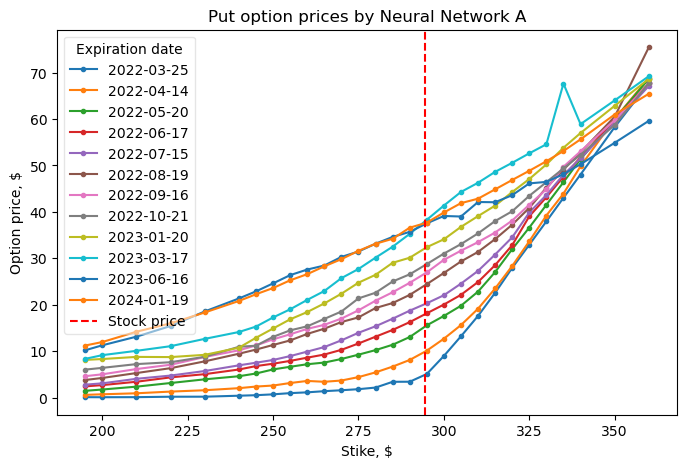

In [165]:
plot_opt_prices(strikes, nn_opt_prices, expirations, title='Put option prices by Neural Network A')

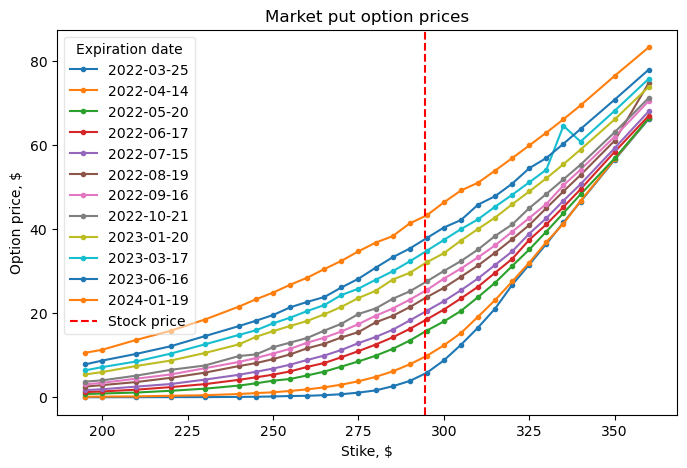

In [141]:
plot_opt_prices(strikes, opt_prices, expirations, title='Market put option prices')

In [166]:
import pickle
with open('nn_opt_prices_1_put.pkl', 'wb') as f:
    pickle.dump(nn_opt_prices, f)

with open('nn_vols_1_put.pkl', 'wb') as f:
    pickle.dump(surface, f)